# Final Project Data603 - Text Classification of Misinformation in PySpark

In [1]:
# spark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, FloatType
from pyspark.sql.functions import *

# visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
import re
from statistics import mean

# model building
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

# model evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix

In [2]:
# create spark session
spark = (SparkSession
         .builder
         .config("spark.executor.memory", "8g")
         .config("spark.driver.memory", "8g")
         .config("spark.sql.autoBroadcastJoinThreshold", "-1")
         .appName('misinfo_classif')
         .getOrCreate()
        )
spark

21/12/08 19:43:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/08 19:43:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
%%html
<!-- this cell improves formatting for spark dataframe .show() output -->
<style>
div.output_area pre {
    white-space: pre;
}
</style>

## 1. Load and Prepare Data

In [4]:
# define schema
schema = (StructType([
            StructField('title', StringType(), False),
            StructField('text', StringType(), False),
            StructField('subject', StringType(), False),
            StructField('date', StringType(), False)])
         )

In [5]:
# load data 
true = spark.read.csv('True.csv', header=True, schema=schema)
fake = spark.read.csv('Fake.csv', header=True, schema=schema)

# cache dataframes
true.cache()
fake.cache()

DataFrame[title: string, text: string, subject: string, date: string]

In [6]:
# print schema
for data in [true, fake]:
    data.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [7]:
true.show()

+--------------------+--------------------+--------------------+------------------+
|               title|                text|             subject|              date|
+--------------------+--------------------+--------------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|        politicsNews|December 29, 2017 |
|Trump on Twitter ...|The following sta...|        politicsNews|December 29,

In [8]:
fake.show()

+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|
| Papa John’s Foun...|A centerpiece of ...|   News|December 21, 2017|
| WATCH: Paul Ryan..

In [9]:
# add target column and merge
true = true.withColumn('target', lit(1))
fake = fake.withColumn('target', lit(0))
all_news = true.union(fake)
all_news.cache()
all_news.show()

+--------------------+--------------------+--------------------+------------------+------+
|               title|                text|             subject|              date|target|
+--------------------+--------------------+--------------------+------------------+------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |     1|
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|December 29, 2017 |     1|
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |     1|
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|December 30, 2017 |     1|
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|December 29, 2017 |     1|
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |     1|
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |     1|
|Factbox: Trump on...|The following sta...|        politicsNews|December 29, 2017 |     1|

In [10]:
# random shuffling of rows
all_news = all_news.orderBy(rand(seed=3))
all_news.show()

+--------------------+--------------------+---------------+-------------------+------+
|               title|                text|        subject|               date|target|
+--------------------+--------------------+---------------+-------------------+------+
|Trump to scrap pr...|WASHINGTON (Reute...|   politicsNews| September 4, 2017 |     1|
| BUSTED: Trump’s ...|It turns out that...|           News|  December 18, 2016|     0|
|White House eyein...|WASHINGTON (Reute...|   politicsNews| November 14, 2017 |     1|
|Message to Presid...|21st Century Wire...|    Middle-east|  February 10, 2017|     0|
|“GOOD-BYE SWEDEN”...|This blogger s pi...|Government News|       Nov 11, 2015|     0|
|MAXINE WATERS Gle...|Rep. Maxine Water...|       politics|        Aug 6, 2017|     0|
|[VIDEO] THEY BURN...|Barack and Michel...|      left-news|       Feb 20, 2016|     0|
|Obama vetoes Sept...|WASHINGTON (Reute...|   politicsNews|September 23, 2016 |     1|
|Return of defeate...|MOSCOW (Reuters) ...|

In [11]:
all_news.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- target: integer (nullable = false)



In [12]:
# small dataset to avoid exceptions due to limitations on memory
all_news = all_news.limit(10000)
all_news.count()

10000

## 2. Examine Data (null values, missing values, duplicates, datatypes)

In [13]:
# show missing values
missing_vals = (all_news
                .select([count(when(isnan(c), c)).alias(c) for c in all_news.columns])
               )
missing_vals.show()

+-----+----+-------+----+------+
|title|text|subject|date|target|
+-----+----+-------+----+------+
|    0|   0|      0|   0|     0|
+-----+----+-------+----+------+



In [14]:
# show blank text values
blank_vals = (all_news
                .select([count(when(col(c)==r' ', c)).alias(c) for c in all_news.columns]))
blank_vals.show()

+-----+----+-------+----+------+
|title|text|subject|date|target|
+-----+----+-------+----+------+
|    0| 151|      0|   0|     0|
+-----+----+-------+----+------+



In [15]:
# show blank text values with double spaces
blank_vals = (all_news
                .select([count(when(col(c)==r'  ', c)).alias(c) for c in all_news.columns]))
blank_vals.show()

+-----+----+-------+----+------+
|title|text|subject|date|target|
+-----+----+-------+----+------+
|    0|   2|      0|   0|     0|
+-----+----+-------+----+------+



In [16]:
# drop blank text values
all_news = all_news.filter(~(col('text')==' '))
all_news = all_news.filter(~(col('text')=='  '))

In [17]:
# duplicates based on text col
num_rows = all_news.select('*').count()
num_distinct_rows = all_news.select(['text']).distinct().count()

print('Number of Total Rows:', num_rows, '\nNumber of Distinct Rows', num_distinct_rows)
print(f'There are {num_rows-num_distinct_rows} rows with duplicates, which should be dropped')

Number of Total Rows: 9845 
Number of Distinct Rows 9547
There are 298 rows with duplicates, which should be dropped


In [18]:
# drop duplicates
all_news = all_news.dropDuplicates(subset=['text'])
all_news.count()

9547

In [19]:
# confirm datatypes
for column in all_news.dtypes:
    print(column[0], ':', column[1])

title : string
text : string
subject : string
date : string
target : int


In [20]:
# date reformatting
# find rows that do not have a date-like format 
all_news = all_news.filter(all_news.date.rlike(r'.+\s\d+,\s\d{4}'))

# standardize month format
def month_reformat(date):
    full_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    date_month = re.findall(r'[a-zA-z]+', date)
    suffix = re.findall(r'[^a-zA-z]+', date)
    for i in range(len(full_month)):
        if full_month[i] == date_month[0]:
            return str(full_month[i][:3]) + str(suffix[0])
    return str(date_month[0]) + str(suffix[0])

# convert to sql udf
month_reformat_udf = udf(month_reformat, StringType())
all_news = all_news.withColumn('date', month_reformat_udf(trim(col('date'))))

# convert to datetime object
all_news = all_news.withColumn('date', to_date(col('date'), "MMM d, yyyy"))
all_news.show()

+--------------------+--------------------+---------------+----------+------+
|               title|                text|        subject|      date|target|
+--------------------+--------------------+---------------+----------+------+
|MUSLIM INVASION O...|    (Welcome) to ...|Government News|2016-06-17|     0|
|WOW! MAJOR CREDIT...|   Delta Air Line...|       politics|2017-06-12|     0|
|FAKE NEWS WEEK: E...|  In response to ...|        US_News|2017-02-08|     0|
|DON’T BELIEVE MED...|  This Facebook u...|      left-news|2016-10-24|     0|
|JUDGE JEANINE PIR...|  https://www.you...|       politics|2017-03-12|     0|
|U.N. envoy told N...| ((This Dec. 9 st...|      worldnews|2017-12-09|     1|
|Trump son-in-law ...| (Corrects Comey ...|   politicsNews|2017-05-25|     1|
|Trump could retur...| (Corrects this N...|   politicsNews|2016-11-15|     1|
|Philadelphia Fox ...| (Editors Note: A...|   politicsNews|2017-01-26|     1|
|Maine Democratic ...| (Editors note: A...|   politicsNews|2017-

## 3. Exploratory Data Analysis

In [21]:
# class distribution
dist = all_news.groupBy('target').count()
dist.show()

+------+-----+
|target|count|
+------+-----+
|     0| 4573|
|     1| 4693|
+------+-----+



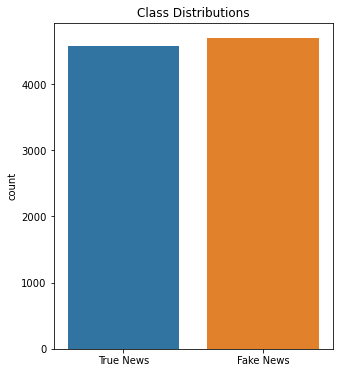

In [22]:
# visualize class distributions
dist_pd = dist.toPandas()
fig, ax = plt.subplots(figsize=(5,6))     
true_fake_counts = dist_pd['count']
categories = ['True News', 'Fake News']
sns.barplot(x=categories, y=true_fake_counts)
plt.title('Class Distributions')  
plt.show()

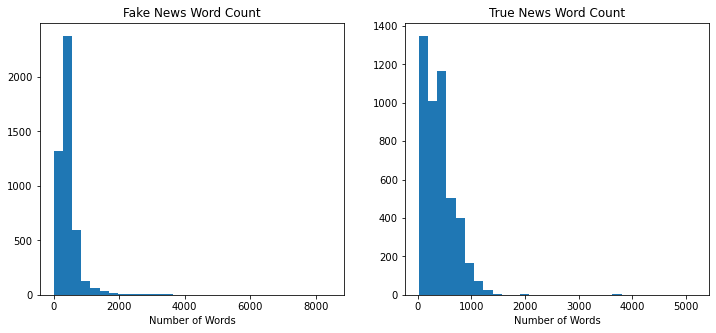

Fake maximum text length: 8435
Fake mean text length: 435.1392958670457 

True maximum text length: 5174
True mean text length: 393.3552098870658


In [23]:
# visualize length of text
# get individual words/tokens
eda_news = all_news.withColumn('words', split(trim(all_news['text']), ' '))
# convert to pandas for visualizations
tokens_df = eda_news.select(col('words'), col('target')).toPandas()
# separate by class
tokens_fake = tokens_df.loc[tokens_df.target == 0]
tokens_true = tokens_df.loc[tokens_df.target == 1]
# get lengths by class
fake_length_words = [len(token_lst) for token_lst in tokens_fake['words']]
true_length_words = [len(token_lst) for token_lst in tokens_true['words']]

# plot distribution of word lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.hist(fake_length_words, bins=30)
ax1.set_title('Fake News Word Count')
ax1.set_xlabel('Number of Words')

ax2.hist(true_length_words, bins=30)
ax2.set_title('True News Word Count')
ax2.set_xlabel('Number of Words')

plt.show()

print('Fake maximum text length:', sorted(fake_length_words, reverse=True)[0])
print('Fake mean text length:', mean(fake_length_words), '\n')

print('True maximum text length:', sorted(true_length_words, reverse=True)[0])
print('True mean text length:', mean(true_length_words))

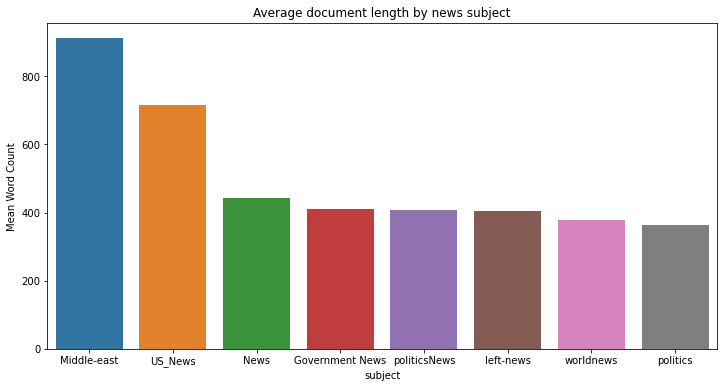

In [24]:
# subject and length
subject_df = eda_news.select(col('words'), col('target'), col('subject')).toPandas()
subject_df['length'] = [len(i) for i in subject_df['words']]
subject_lengths = subject_df['length'].groupby(subject_df['subject']).mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12,6))     
sns.barplot(x=subject_lengths.index,
            y=subject_lengths)
plt.title('Average document length by news subject')
plt.ylabel('Mean Word Count')
plt.show()

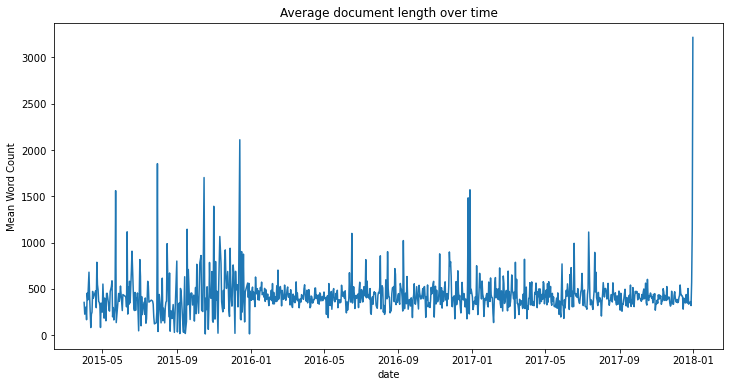

In [25]:
# date and length 
date_df = eda_news.select(col('words'), col('target'), col('date')).toPandas()
date_df['length'] = [len(i) for i in subject_df['words']]
date_length = date_df['length'].groupby(date_df['date']).mean()

fig, ax = plt.subplots(figsize=(12,6))     
sns.lineplot(x=date_length.index,
            y=date_length)
plt.title('Average document length over time')
plt.ylabel('Mean Word Count')
plt.show()

## 4. Text Cleaning

In [26]:
# remove rows that contain Twitter metadata or just website links
all_news = all_news.filter(~all_news.text.rlike(r'The following statements'))
all_news = all_news.filter(~all_news.text.rlike(r'^http'))

In [27]:
# remove punctuation, extra whitespace, special characters
def clean_text(doc):
    doc = re.sub(r'.*\(Reuters\)\s\-', '', doc)  # remove (Reuters) that exists at beginning of true news record
    doc = re.sub(r'[^\w\s]', '', doc.lower().strip())  # remove any character except word and space characters
    return doc

clean_text_udf = udf(clean_text, StringType())

all_news = all_news.withColumn('clean_text', clean_text_udf(col('text')))
all_news.show()

+--------------------+--------------------+---------------+----------+------+--------------------+
|               title|                text|        subject|      date|target|          clean_text|
+--------------------+--------------------+---------------+----------+------+--------------------+
|MUSLIM INVASION O...|    (Welcome) to ...|Government News|2016-06-17|     0|welcome to americ...|
|WOW! MAJOR CREDIT...|   Delta Air Line...|       politics|2017-06-12|     0|delta air lines a...|
|FAKE NEWS WEEK: E...|  In response to ...|        US_News|2017-02-08|     0|in response to th...|
|DON’T BELIEVE MED...|  This Facebook u...|      left-news|2016-10-24|     0|this facebook use...|
|JUDGE JEANINE PIR...|  https://www.you...|       politics|2017-03-12|     0|httpswwwyoutubeco...|
|U.N. envoy told N...| ((This Dec. 9 st...|      worldnews|2017-12-09|     1|the united nation...|
|Trump son-in-law ...| (Corrects Comey ...|   politicsNews|2017-05-25|     1|president donald ...|
|Trump cou

## 5. Train Test Split

In [28]:
# split the data into train (80%) and test (20%)
train_news, test_news = all_news.randomSplit([0.8, 0.2], seed=3)

## 6. Text Preprocessing and Featurization

In [29]:
# create preprocessing and featurization pipeline
# get tokens
tokenizer = Tokenizer(inputCol='clean_text', outputCol='tokens')
# remove stopwords
remover = StopWordsRemover(inputCol='tokens', outputCol='tokens_no_stopwords')
# determine term frequency with count vectorizer
vectorizer = CountVectorizer(inputCol='tokens_no_stopwords', outputCol='rawFeatures')
# determine idf
idf = IDF(inputCol='rawFeatures', outputCol='features')
# create pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf])
# fit pipeline to dataframe
model = pipeline.fit(train_news)

21/12/08 19:45:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB


In [30]:
# transform train and test sets with pipeline
train_news = model.transform(train_news)
test_news = model.transform(test_news)
# cache train and test sets
train_news.cache()
test_news.cache()

DataFrame[title: string, text: string, subject: string, date: date, target: int, clean_text: string, tokens: array<string>, tokens_no_stopwords: array<string>, rawFeatures: vector, features: vector]

## 7. Logistic Regression Model

In [31]:
# instantiate logistic regression model
lr = LogisticRegression(labelCol='target', featuresCol='features')
# fit model
lr_model = lr.fit(train_news)
# make predictions
target_pred = lr_model.transform(test_news)

21/12/08 19:46:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
21/12/08 19:48:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:02 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/08 19:48:02 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/12/08 19:48:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
21/12/08 19:48:

In [32]:
# evaluate model 
# Area under curve
evaluator = BinaryClassificationEvaluator(labelCol='target', metricName='areaUnderROC')
AUC = evaluator.evaluate(target_pred)
print('Area Under Curve for Logistic Regression Model:', AUC)

# calculate accuracy
accuracy = target_pred.filter(col('target') == col('prediction')).count() / float(test_news.count())
print('Accuracy for Logistic Regression Model:', accuracy)

21/12/08 19:48:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Area Under Curve for Logistic Regression Model: 0.9635919609159664


21/12/08 19:49:18 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
21/12/08 19:49:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Accuracy for Logistic Regression Model: 0.9110867178924259


In [33]:
target_pred.show()

+--------------------+--------------------+-------+----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|               title|                text|subject|      date|target|          clean_text|              tokens| tokens_no_stopwords|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-------+----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| #NeverTrump Cons...|Donald Trump is b...|   News|2017-03-01|     0|donald trump is b...|[donald, trump, i...|[donald, trump, g...|(83595,[0,1,2,4,5...|(83595,[0,1,2,4,5...|[46.6937094704608...|           [1.0,0.0]|       0.0|
| 40 Million Bad*s...|According to an o...|   News|2016-01-05|     0|according to an o..

21/12/08 19:49:19 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


21/12/08 19:49:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
21/12/08 19:49:20 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


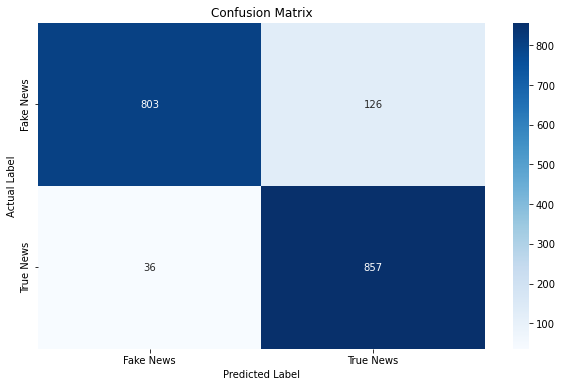

In [34]:
# confusion matrix
y_true = target_pred.select(col('target'))
y_true = y_true.toPandas()
y_pred = target_pred.select(col('prediction'))
y_pred = y_pred.toPandas()

cf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,6))     
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', 
                 xticklabels=['Fake News', 'True News'], 
                 yticklabels=['Fake News', 'True News'],
                 cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix')
plt.show()

In [35]:
# examine feature importance
# get coefficients
weights = lr_model.coefficients
weights = [(float(w),) for w in weights]

# get tokens from feature vector
feature_names = model.stages[2].vocabulary

weight_feature_df = spark.createDataFrame(zip(weights, feature_names), schema= ['coefficients', 'featureName'])
weight_feature_df1 = weight_feature_df.sort(asc('coefficients'))

In [36]:
weight_feature_df1.show()

+--------------------+-------------------+
|        coefficients|        featureName|
+--------------------+-------------------+
|{-12.127850097677...|       yearbringing|
|{-12.127850097677...|        expeditions|
|{-12.127850097677...|               tock|
|{-12.127850097677...|            inkling|
|{-12.127850097677...|   watchseanhannity|
|{-12.127850097677...| httpstcoti7ycn7auf|
|{-12.127850097677...|         computeras|
|{-12.127850097677...|discoveredyesterday|
|{-12.127850097677...|               666b|
|{-12.127850097677...|          todaylast|
|{-12.127850097677...|             showon|
|{-12.127850097677...|               5774|
|{-12.127850097677...|       tenambetween|
|{-12.127850097677...|  interviewsfederal|
|{-12.127850097677...|          today4767|
|{-12.127850097677...|               7616|
|{-12.127850097677...|               5707|
|{-12.127850097677...|         electionmr|
|{-12.127850097677...|     electionmccabe|
|{-12.127850097677...|        laterrather|
+----------

In [37]:
weight_feature_df2 = weight_feature_df.sort(desc('coefficients'))

In [38]:
weight_feature_df2.show()

+--------------------+------------------+
|        coefficients|       featureName|
+--------------------+------------------+
| {7.303274381425323}|            leaner|
| {6.212181171375291}|              1300|
| {6.138760758133321}|             katya|
| {6.019484064105074}|            abbate|
| {5.983334094903243}|          hotheads|
| {5.895178485632622}|           phasing|
| {5.748111677698628}|              amaq|
| {5.668174330492895}|     grandstanders|
| {5.586677571273747}|          kermadec|
|{5.3990643570559005}|       presidency |
| {5.340904375586592}|          jfkfiles|
| {5.225758503681253}|             annul|
|  {5.13588442546609}|       summarizing|
| {5.079913888576876}|        bring more|
|{5.0592041645437344}|          knifeman|
| {4.870090742326353}|            linzer|
| {4.870090742326353}|           makeups|
| {4.870090742326353}|        predictors|
| {4.870090742326353}|      moreeducated|
| {4.870090742326353}|higherthanexpected|
+--------------------+------------